In [ ]:
!pip install dwave-ocean-sdk matplotlib networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.6/158.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.7/103.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.8 MB/s eta 0:00:00


In [ ]:
from dwave.system import DWaveSampler
from dwave.cloud import Client

# Set up the D-Wave API token
Client.from_config(token='D-wave API')

sampler = DWaveSampler(token='token')
print("Connected to D-Wave Sampler:", sampler.properties['chip_id'])

Connected to D-Wave Sampler: Advantage_system4.1



Best Solution: {'x_A_0': 1, 'x_A_1': 0, 'x_B_0': 0, 'x_B_1': 1, 'x_C_0': 0, 'x_C_1': 1}

Optimal Schedule: {'A': 0, 'B': 1, 'C': 1}


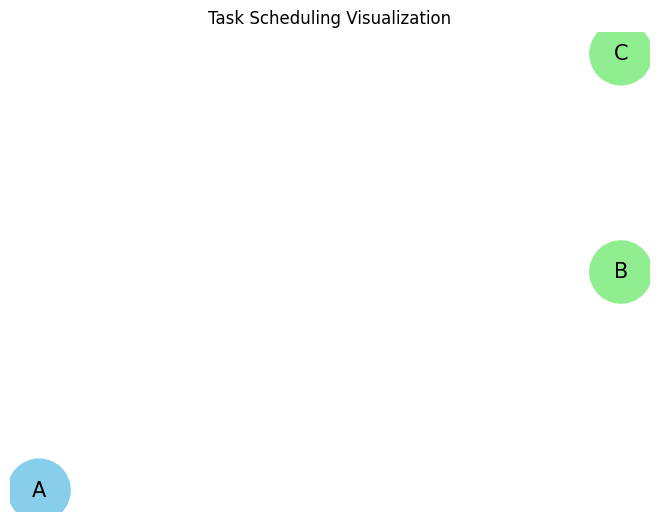

In [ ]:
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite
import networkx as nx
import matplotlib.pyplot as plt



# Define the problem parameters
tasks = ['A', 'B', 'C']  # Tasks to be scheduled
time_slots = [0, 1]  # Available time slots

# Constraints:
# - A and B cannot run at the same time
# - C must run in time slot 1
constraints = {
    'not_together': [('A', 'B')],
    'fixed_slot': {'C': 1}
}

# Build QUBO
def build_scheduling_qubo(tasks, time_slots, constraints):
    Q = {}

    # Variable: x_{task}_{time} -> 1 if task is scheduled at time slot
    # Objective: Each task should be scheduled in exactly one time slot
    for task in tasks:
        for t in time_slots:
            Q[(f'x_{task}_{t}', f'x_{task}_{t}')] = -1  # Favor assigning each task to one time slot

        for t1 in time_slots:
            for t2 in time_slots:
                if t1 != t2:
                    Q[(f'x_{task}_{t1}', f'x_{task}_{t2}')] = 2  # Penalize assigning the same task twice

    # Constraint: A and B cannot be scheduled together
    for task1, task2 in constraints['not_together']:
        for t in time_slots:
            Q[(f'x_{task1}_{t}', f'x_{task2}_{t}')] = 2  # Penalize if both are scheduled at the same time slot

    # Constraint: Fixed time slot for task C
    if 'C' in constraints['fixed_slot']:
        required_slot = constraints['fixed_slot']['C']
        for t in time_slots:
            if t != required_slot:
                Q[(f'x_C_{t}', f'x_C_{t}')] = 5  # Heavy penalty for assigning C to wrong time slot

    return Q

# Build the QUBO
qubo = build_scheduling_qubo(tasks, time_slots, constraints)

# Solve with Quantum Annealer
sampler = EmbeddingComposite(DWaveSampler(token='DEV-07e460ddabbe1157f031ab0b4cde6131619a919e'))  # Use the real D-Wave hardware or a simulated environment # Pass the API token to the DWaveSampler constructor here
response = sampler.sample_qubo(qubo, num_reads=100)


# Extract the best solution
best_solution = response.first.sample
print("\nBest Solution:", best_solution)

# Interpret the solution
def interpret_solution(solution, tasks, time_slots):
    schedule = {}
    for task in tasks:
        for t in time_slots:
            if solution.get(f'x_{task}_{t}', 0) == 1:
                schedule[task] = t
    return schedule

schedule = interpret_solution(best_solution, tasks, time_slots)
print("\nOptimal Schedule:", schedule)

# Visualization
def visualize_schedule(schedule):
    G = nx.Graph()
    for task, slot in schedule.items():
        G.add_node(task, time_slot=slot)

    pos = {}
    for i, (task, slot) in enumerate(schedule.items()):
        pos[task] = (slot, i)

    colors = ['skyblue' if slot == 0 else 'lightgreen' for slot in schedule.values()]
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2000, font_size=15, font_color='black')
    plt.title('Task Scheduling Visualization')
    plt.show()

visualize_schedule(schedule)

**More complex:**


Best Solution: {'x_A_0': 0, 'x_A_1': 1, 'x_A_2': 0, 'x_B_0': 0, 'x_B_1': 0, 'x_B_2': 1, 'x_C_0': 0, 'x_C_1': 0, 'x_C_2': 0, 'x_D_0': 1, 'x_D_1': 0, 'x_D_2': 0, 'x_E_0': 0, 'x_E_1': 0, 'x_E_2': 0}

Optimal Schedule: {'A': 1, 'B': 2, 'D': 0}


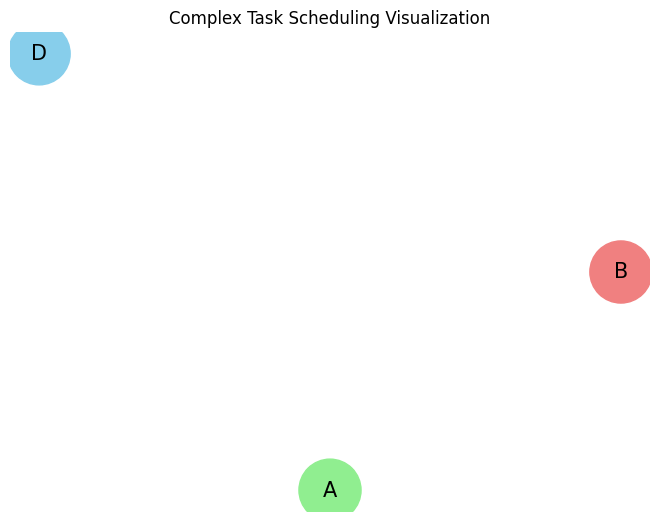

In [ ]:
tasks = ['A', 'B', 'C', 'D', 'E']
time_slots = [0, 1, 2]

# Constraints
constraints = {
    'task_dependencies': [('A', 'B')],  # B starts after A finishes
    'not_together': [('C', 'D')],       # C and D cannot run at the same time
    'fixed_slot': {'E': 2},             # E must run at time slot 2
    'max_tasks_per_slot': 2             # No more than 2 tasks per time slot
}


def build_complex_scheduling_qubo(tasks, time_slots, constraints):
    Q = {}

    # Each task must be assigned to exactly one time slot
    for task in tasks:
        for t in time_slots:
            Q[(f'x_{task}_{t}', f'x_{task}_{t}')] = -1  # Reward assigning a task to one time slot
        for t1 in time_slots:
            for t2 in time_slots:
                if t1 != t2:
                    Q[(f'x_{task}_{t1}', f'x_{task}_{t2}')] = 2  # Penalize assigning task to multiple slots

    # Task dependencies
    for task1, task2 in constraints.get('task_dependencies', []):
        for t in range(len(time_slots) - 1):
            Q[(f'x_{task1}_{t}', f'x_{task2}_{t+1}')] = -1  # Reward valid dependency
            for t2 in range(t):
                Q[(f'x_{task1}_{t}', f'x_{task2}_{t2}')] = 5  # Heavy penalty if order is violated

    # Tasks that cannot run together
    for task1, task2 in constraints.get('not_together', []):
        for t in time_slots:
            Q[(f'x_{task1}_{t}', f'x_{task2}_{t}')] = 3  # Penalize same time slot

    # Fixed slot for specific tasks
    for task, slot in constraints.get('fixed_slot', {}).items():
        for t in time_slots:
            if t != slot:
                Q[(f'x_{task}_{t}', f'x_{task}_{t}')] = 5  # Penalize wrong slot

    # Limit maximum tasks per time slot
    for t in time_slots:
        tasks_in_slot = [f'x_{task}_{t}' for task in tasks]
        for i, task1 in enumerate(tasks_in_slot):
            for task2 in tasks_in_slot[i+1:]:
                Q[(task1, task2)] = 2  # Penalize exceeding task limit in the same slot

    return Q

# Build the QUBO
qubo = build_complex_scheduling_qubo(tasks, time_slots, constraints)

# Solve with Quantum Annealer
sampler = EmbeddingComposite(DWaveSampler(token='DEV-07e460ddabbe1157f031ab0b4cde6131619a919e'))  # Use the real D-Wave hardware or a simulated environment # Pass the API token to the DWaveSampler constructor here
response = sampler.sample_qubo(qubo, num_reads=100)

best_solution = response.first.sample
print("\nBest Solution:", best_solution)

# Interpret the solution
def interpret_solution(solution, tasks, time_slots):
    schedule = {}
    for task in tasks:
        for t in time_slots:
            if solution.get(f'x_{task}_{t}', 0) == 1:
                schedule[task] = t
    return schedule

schedule = interpret_solution(best_solution, tasks, time_slots)
print("\nOptimal Schedule:", schedule)

# Visualization
def visualize_schedule(schedule):
    G = nx.Graph()
    for task, slot in schedule.items():
        G.add_node(task, time_slot=slot)

    pos = {}
    for i, (task, slot) in enumerate(schedule.items()):
        pos[task] = (slot, i)

    colors = ['skyblue' if slot == 0 else 'lightgreen' if slot == 1 else 'lightcoral' for slot in schedule.values()]
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2000, font_size=15, font_color='black')
    plt.title('Complex Task Scheduling Visualization')
    plt.show()

visualize_schedule(schedule)


asks: 10 tasks (P1 – P10)

Shifts: 7 daily shifts (Shift 1 – Shift 7)

Nurses: 3 nurses (Nurse A, Nurse B, Nurse C)

Constraints:
Specific dependencies between tasks (e.g., P3 must happen before P7).

Some tasks cannot overlap in the same shift (P2, P6).

Patients have preferences for specific nurses (P1 → Nurse A).

Max 3 tasks per shift.


Best Solution: {'x_P10_S1': 0, 'x_P10_S2': 0, 'x_P10_S3': 0, 'x_P10_S4': 0, 'x_P10_S5': 0, 'x_P10_S6': 1, 'x_P10_S7': 0, 'x_P1_Nurse A_S1': 1, 'x_P1_Nurse A_S2': 1, 'x_P1_Nurse A_S3': 1, 'x_P1_Nurse A_S4': 1, 'x_P1_Nurse A_S5': 1, 'x_P1_Nurse A_S6': 1, 'x_P1_Nurse A_S7': 1, 'x_P1_S1': 1, 'x_P1_S2': 0, 'x_P1_S3': 0, 'x_P1_S4': 0, 'x_P1_S5': 0, 'x_P1_S6': 0, 'x_P1_S7': 0, 'x_P2_S1': 0, 'x_P2_S2': 0, 'x_P2_S3': 0, 'x_P2_S4': 0, 'x_P2_S5': 0, 'x_P2_S6': 0, 'x_P2_S7': 0, 'x_P3_S1': 0, 'x_P3_S2': 1, 'x_P3_S3': 0, 'x_P3_S4': 0, 'x_P3_S5': 0, 'x_P3_S6': 0, 'x_P3_S7': 0, 'x_P4_S1': 0, 'x_P4_S2': 0, 'x_P4_S3': 0, 'x_P4_S4': 0, 'x_P4_S5': 0, 'x_P4_S6': 0, 'x_P4_S7': 0, 'x_P5_Nurse B_S1': 1, 'x_P5_Nurse B_S2': 1, 'x_P5_Nurse B_S3': 1, 'x_P5_Nurse B_S4': 1, 'x_P5_Nurse B_S5': 1, 'x_P5_Nurse B_S6': 1, 'x_P5_Nurse B_S7': 1, 'x_P5_S1': 0, 'x_P5_S2': 0, 'x_P5_S3': 0, 'x_P5_S4': 0, 'x_P5_S5': 1, 'x_P5_S6': 0, 'x_P5_S7': 0, 'x_P6_S1': 0, 'x_P6_S2': 0, 'x_P6_S3': 0, 'x_P6_S4': 0, 'x_P6_S5': 0, 'x_P6_S6':

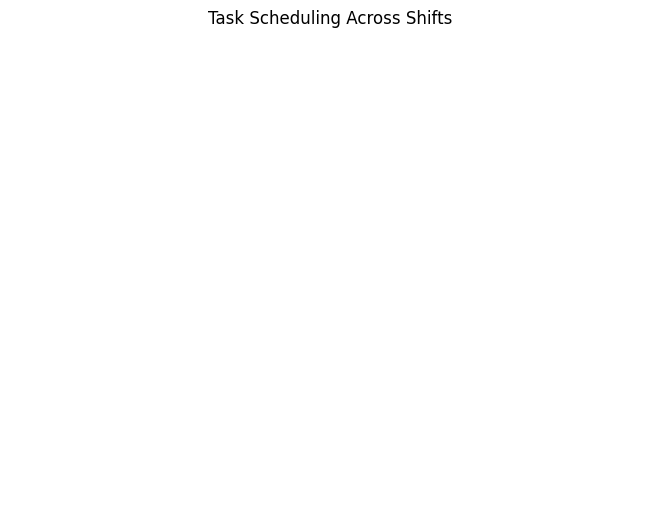

Empty DataFrame
Columns: [Task, Assigned Shift]
Index: []


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

tasks = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']
shifts = [1, 2, 3, 4, 5, 6, 7]
nurses = ['Nurse A', 'Nurse B', 'Nurse C']
max_tasks_per_shift = 3

# Constraints
constraints = {
    'task_dependencies': [('P3', 'P7')],  # P3 must be before P7
    'not_together': [('P2', 'P6')],       # P2 and P6 cannot run in the same shift
    'fixed_nurse': {'P1': 'Nurse A', 'P5': 'Nurse B'},  # Patient preferences
    'max_tasks_per_shift': max_tasks_per_shift
}

# Build QUBO
def build_complex_scheduling_qubo(tasks, shifts, nurses, constraints):
    Q = {}

    # Each task must be assigned to exactly one shift
    for task in tasks:
        for shift in shifts:
            Q[(f'x_{task}_S{shift}', f'x_{task}_S{shift}')] = -1  # Reward assignment to a shift
        for s1 in shifts:
            for s2 in shifts:
                if s1 != s2:
                    Q[(f'x_{task}_S{s1}', f'x_{task}_S{s2}')] = 2  # Penalize multiple shift assignments

    # Task dependencies
    for task1, task2 in constraints.get('task_dependencies', []):
        for s1 in range(1, len(shifts)):
            for s2 in range(s1):
                Q[(f'x_{task1}_S{s1}', f'x_{task2}_S{s2}')] = 5  # Penalize order violation

    # Tasks that cannot run together
    for task1, task2 in constraints.get('not_together', []):
        for shift in shifts:
            Q[(f'x_{task1}_S{shift}', f'x_{task2}_S{shift}')] = 3  # Penalize same shift

    # Nurse preferences
    for task, nurse in constraints.get('fixed_nurse', {}).items():
        for shift in shifts:
            Q[(f'x_{task}_{nurse}_S{shift}', f'x_{task}_{nurse}_S{shift}')] = -5  # Reward preferred nurse assignment

    # Limit tasks per shift
    for shift in shifts:
        shift_tasks = [f'x_{task}_S{shift}' for task in tasks]
        for i in range(len(shift_tasks)):
            for j in range(i+1, len(shift_tasks)):
                Q[(shift_tasks[i], shift_tasks[j])] = 2  # Penalize exceeding max task per shift

    return Q
# Build the QUBO
qubo = build_complex_scheduling_qubo(tasks, shifts, nurses, constraints)


# Solve with Quantum Annealer
sampler = EmbeddingComposite(DWaveSampler(token='DEV-07e460ddabbe1157f031ab0b4cde6131619a919e'))  # Use the real D-Wave hardware or a simulated environment # Pass the API token to the DWaveSampler constructor here
response = sampler.sample_qubo(qubo, num_reads=100)

best_solution = response.first.sample
print("\nBest Solution:", best_solution)

# Interpret the solution
def interpret_solution(solution, tasks, time_slots):
    schedule = {}
    for task in tasks:
        for t in time_slots:
            if solution.get(f'x_{task}_{t}', 0) == 1:
                schedule[task] = t
    return schedule

schedule = interpret_solution(best_solution, tasks, time_slots)
print("\nOptimal Schedule:", schedule)


# Visualization Function
def visualize_schedule(schedule):
    G = nx.DiGraph()

    # Add nodes (tasks) with their assigned shifts
    for task, slot in schedule.items():
        G.add_node(task, shift=slot)

    # Position nodes based on their shift for better visualization
    pos = {}
    shift_positions = {}
    for task, shift in schedule.items():
        shift_num = int(shift.split()[1])  # Extract shift number
        if shift_num not in shift_positions:
            shift_positions[shift_num] = 0
        pos[task] = (shift_num, shift_positions[shift_num])
        shift_positions[shift_num] += 1  # Stagger nodes vertically per shift

    # Assign colors to represent shifts
    colors = [plt.cm.tab10(int(shift.split()[1]) % 10) for shift in schedule.values()]

    # Draw the graph
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=colors,
        node_size=2000,
        font_size=10,
        font_color='white',
        font_weight='bold'
    )

    plt.title('Task Scheduling Across Shifts')
    plt.xlabel('Shifts')
    plt.ylabel('Tasks')
    plt.show()

visualize_schedule(schedule)

import pandas as pd

# Display schedule in table format
def display_schedule_table(schedule):
    df = pd.DataFrame(list(schedule.items()), columns=['Task', 'Assigned Shift'])
    df = df.sort_values(by='Assigned Shift')  # Sort tasks by shift for clarity
    print(df)
    return df

# Display the table
schedule_table = display_schedule_table(schedule)


Genetic

In [ ]:
import random

# Parameters
TASKS = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']
SHIFTS = [1, 2, 3, 4, 5, 6, 7]
NURSES = ['Nurse A', 'Nurse B', 'Nurse C']
POPULATION_SIZE = 100
GENERATIONS = 200
MUTATION_RATE = 0.1

# Constraints
PREFERENCES = {
    'P1': 'Nurse A',
    'P5': 'Nurse B'
}

ORDER_CONSTRAINTS = [
    ('P3', 'P7')  # P3 must happen before P7
]

EXCLUSION_CONSTRAINTS = [
    ('P2', 'P6')
]

MAX_PATIENTS_PER_SHIFT = 3


# Fitness Function
def fitness(schedule):
    score = 0

    # Preference Satisfaction
    for task, assignment in schedule.items():
        nurse, shift = assignment
        if task in PREFERENCES and nurse != PREFERENCES[task]:
            score -= 5  # Penalize if nurse preference is not met

    # Order Constraints
    for task1, task2 in ORDER_CONSTRAINTS:
        shift1 = schedule[task1][1]
        shift2 = schedule[task2][1]
        if shift1 >= shift2:
            score -= 10  # Penalize if order is violated

    # Exclusion Constraints
    for task1, task2 in EXCLUSION_CONSTRAINTS:
        if schedule[task1][1] == schedule[task2][1]:
            score -= 5  # Penalize if exclusion violated

    # Shift Capacity Constraint
    shift_count = {shift: 0 for shift in SHIFTS}
    for _, (_, shift) in schedule.items():
        shift_count[shift] += 1

    for shift, count in shift_count.items():
        if count > MAX_PATIENTS_PER_SHIFT:
            score -= 5 * (count - MAX_PATIENTS_PER_SHIFT)

    return score


# Generate Initial Population
def generate_population():
    population = []
    for _ in range(POPULATION_SIZE):
        schedule = {
            task: (random.choice(NURSES), random.choice(SHIFTS))
            for task in TASKS
        }
        population.append(schedule)
    return population


# Selection
def selection(population):
    population = sorted(population, key=lambda x: fitness(x), reverse=True)
    return population[:POPULATION_SIZE // 2]


# Crossover
def crossover(parent1, parent2):
    child = {}
    for task in TASKS:
        if random.random() > 0.5:
            child[task] = parent1[task]
        else:
            child[task] = parent2[task]
    return child


# Mutation
def mutate(schedule):
    if random.random() < MUTATION_RATE:
        task = random.choice(TASKS)
        schedule[task] = (random.choice(NURSES), random.choice(SHIFTS))
    return schedule


# Genetic Algorithm
def genetic_algorithm():
    population = generate_population()
    best_schedule = None
    best_fitness = float('-inf')

    for generation in range(GENERATIONS):
        population = selection(population)
        new_population = []

        while len(new_population) < POPULATION_SIZE:
            parent1, parent2 = random.sample(population, 2)
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)

        population = new_population

        for schedule in population:
            current_fitness = fitness(schedule)
            if current_fitness > best_fitness:
                best_fitness = current_fitness
                best_schedule = schedule

        print(f"Generation {generation}: Best Fitness = {best_fitness}")

    return best_schedule


# Run Genetic Algorithm
best_solution = genetic_algorithm()
print("\nBest Schedule (Genetic Algorithm):")
for task, (nurse, shift) in best_solution.items():
    print(f"{task}: Nurse {nurse}, Shift {shift}")


Generation 0: Best Fitness = 0
Generation 1: Best Fitness = 0
Generation 2: Best Fitness = 0
Generation 3: Best Fitness = 0
Generation 4: Best Fitness = 0
Generation 5: Best Fitness = 0
Generation 6: Best Fitness = 0
Generation 7: Best Fitness = 0
Generation 8: Best Fitness = 0
Generation 9: Best Fitness = 0
Generation 10: Best Fitness = 0
Generation 11: Best Fitness = 0
Generation 12: Best Fitness = 0
Generation 13: Best Fitness = 0
Generation 14: Best Fitness = 0
Generation 15: Best Fitness = 0
Generation 16: Best Fitness = 0
Generation 17: Best Fitness = 0
Generation 18: Best Fitness = 0
Generation 19: Best Fitness = 0
Generation 20: Best Fitness = 0
Generation 21: Best Fitness = 0
Generation 22: Best Fitness = 0
Generation 23: Best Fitness = 0
Generation 24: Best Fitness = 0
Generation 25: Best Fitness = 0
Generation 26: Best Fitness = 0
Generation 27: Best Fitness = 0
Generation 28: Best Fitness = 0
Generation 29: Best Fitness = 0
Generation 30: Best Fitness = 0
Generation 31: Bes